<a href="https://colab.research.google.com/github/spatank/Curiosity/blob/master/v4/persistent_homology_KNOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/Curiosity/')

Mounted at /content/drive


In [2]:
!ls # run !ls to verify location

KNOT  persistent_homology_KNOT.ipynb  Wiki


In [3]:
import glob
import scipy
import scipy.io as sio
from scipy.io import savemat

In [4]:
import sys
!{sys.executable} -m pip install Cython

In [5]:
import sys
!{sys.executable} -m pip install Ripser

     |████████████████████████████████| 71kB 3.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 51kB 4.6MB/s 
  Created wheel for Ripser: filename=ripser-0.6.0-cp37-cp37m-linux_x86_64.whl size=454935 sha256=d9e81495e1b44a55035ad2cbc6845bd42c6beae50797f47338aa73088fdac8c8
  Stored in directory: /root/.cache/pip/wheels/95/1e/13/59da989de59903698d767dcb19414163e683a2dd31edf80417
Successfully built Ripser
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18091 sha256=7378d8d7ebbfb8cfa082b15418beebb3306101b23690b6cdbd4cb97339a91c94
  Stored in directory: /root/.cache/pip/wheels/2b/e1/c9/1993c7f7f114b7d3fb2d3e895e02157a7ebf554861e9e54e01
Successfully built hopcroftkarp


In [6]:
from ripser import ripser
import numpy as np
import matplotlib.pyplot as plt

def get_barcode(filt_mat, maxdim = 2):
    """
    Calculates the persistent homology for a given filtration matrix
    ``filt_mat``, default dimensions 0 through 2. Wraps ripser.
    """
    b = ripser(filt_mat, distance_matrix = True, maxdim = maxdim)['dgms']
    return list(zip(range(maxdim + 1), b))

def plot_barcode(bars, length, dims = [0, 1, 2], end = True):
    """
    Takes in bars, as generated by, e.g., ripser, and plots the barcode.
    """
    bars = dict(bars)
    count = 1
    has_inf = False
    colors = ['xkcd:emerald green', 'xkcd:tealish', 'xkcd:peacock blue']
    # iterate through dimension
    for d in dims:
        bn = bars[d]
        bn = sorted(bn, key = lambda x: x[0])
        for b, i in zip(bn, range(len(bn))):
            # extend in the case of infinite cycles
            if b[1] == np.inf:
                has_inf = True
                b = (b[0], 1.3*length)
            # plot first one with label
            if i == 0:
                plt.plot(b, [count, count], color = colors[d],
                         label='{}-cycles'.format(d))
            else:
                plt.plot(b, [count, count], color = colors[d])
            count += 1
        count += 1
    # add end of filtration line
    plt.axvline(x = length, color = 'xkcd:grey', alpha = 0.5, linestyle = ':')
    if end:
        plt.annotate('Filtration End', (length + 10, 0.5 * count), rotation = 270,
                     color = 'xkcd:grey', alpha = 0.5)
    lims = plt.xlim()
    plt.xlim([-0.05 * length, length * 1.05])
    plt.xlabel('Nodes')
    plt.ylabel('Cycle Number')

def betti_curves(bars, length):
    """
    Takes in bars and returns the betti curves
    """
    bettis = np.zeros((len(bars), length))
    for i in range(bettis.shape[0]):
        bn = bars[i][1]
        for bar in bn:
            birth = int(bar[0])
            death = length+1 if np.isinf(bar[1]) else int(bar[1]+1)
            bettis[i][birth:death] += 1
    return bettis

In [7]:
files = glob.glob('/content/drive/My Drive/Curiosity/KNOT/Preprocessed/*.mat')
mat_file = files[0]

In [8]:
# test code with Subject 101
mat_contents = sio.loadmat(mat_file)

subj = mat_contents['subj']
orig_G = mat_contents['orig_G']
nodes = mat_contents['nodes']

nodes_kept = mat_contents['nodes_kept']
G = mat_contents['G']
weighted_G = mat_contents['weighted_G']

edges_rewired_weighted = mat_contents['edges_rewired_weighted']
new_node_order = mat_contents['new_node_order']
nodes_reordered_weighted = mat_contents['nodes_reordered_weighted']

In [9]:
# Run persistent homology analysis for true data
bars_orig = get_barcode(weighted_G)
bettis_orig = betti_curves(bars_orig, len(nodes_kept))
print('Original processed!')

# Run persistent homology for null models
# num_iters = edges_rewired_weighted.shape[2]
num_iters = 10
bettis_0_edges_rewired = []
bettis_1_edges_rewired = []
bettis_2_edges_rewired = []
bettis_0_nodes_reordered = []
bettis_1_nodes_reordered = []
bettis_2_nodes_reordered = []

for i in range(num_iters):

  bars_edges_rewired = get_barcode(edges_rewired_weighted[:, :, i])
  bettis_edges_rewired = betti_curves(bars_edges_rewired, len(nodes_kept))
  bettis_0_edges_rewired.append(bettis_edges_rewired[0])
  bettis_1_edges_rewired.append(bettis_edges_rewired[1])
  bettis_2_edges_rewired.append(bettis_edges_rewired[2])

  bars_nodes_reordered = get_barcode(nodes_reordered_weighted[:, :, i])
  bettis_nodes_reordered = betti_curves(bars_nodes_reordered, len(nodes_kept))
  bettis_0_nodes_reordered.append(bettis_nodes_reordered[0])
  bettis_1_nodes_reordered.append(bettis_nodes_reordered[1])
  bettis_2_nodes_reordered.append(bettis_nodes_reordered[2])

  print('Null iteration %d processed!' % i)

Original processed!
Null iteration 0 processed!
Null iteration 1 processed!
Null iteration 2 processed!
Null iteration 3 processed!
Null iteration 4 processed!
Null iteration 5 processed!
Null iteration 6 processed!
Null iteration 7 processed!
Null iteration 8 processed!
Null iteration 9 processed!


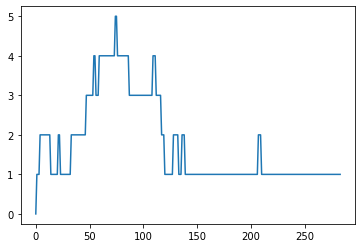

In [10]:
plt.plot(bettis_orig[0])

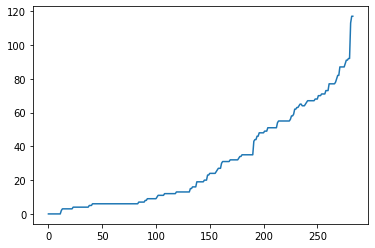

In [11]:
plt.plot(bettis_orig[1])

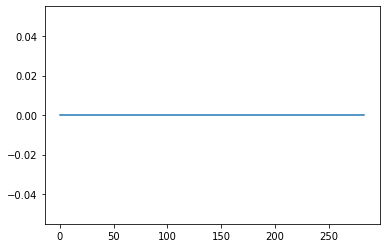

In [12]:
plt.plot(bettis_orig[2])

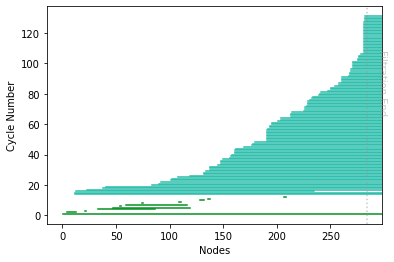

In [13]:
plot_barcode(bars_orig, len(nodes_kept))

In [14]:
save_filename = '_'.join(mat_file.split('/')[7].split('_')[:2]) + '_bettis.mat'
mdic = {'bettis_orig': bettis_orig, 
        'bettis_0_edges_rewired': bettis_0_edges_rewired, 
        'bettis_1_edges_rewired': bettis_1_edges_rewired,
        'bettis_2_edges_rewired': bettis_2_edges_rewired,
        'bettis_0_nodes_reordered': bettis_0_nodes_reordered,
        'bettis_1_nodes_reordered': bettis_1_nodes_reordered,
        'bettis_2_nodes_reordered': bettis_2_nodes_reordered}
savemat(save_filename, mdic)